In [1]:
import os
import pickle
import gc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
from openretina.hoefling_2024.configs import model_config, trainer_config
from openretina.hoefling_2024.data_io import natmov_dataloaders_v2
from openretina.hoefling_2024.models import SFB3d_core_SxF3d_readout
from openretina.hoefling_2024.nnfabrik_model_loading import load_ensemble_retina_model_from_directory
from openretina.neuron_data_io import make_final_responses
from openretina.training import standard_early_stop_trainer as trainer
from openretina.utils.h5_handling import load_h5_into_dict
from openretina.utils.misc import CustomPrettyPrinter
from rgc_natstim_model.constants.plot_settings import cmap_colors as rgc_colors

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4, max_lines=40)

from scipy.stats import pearsonr as lincorr

from functools import partial

import sys
sys.path.append('/gpfs01/euler/User/lhoefling/GitHub/nnfabrik_euler')

# Import constants

In [5]:
from rgc_natstim_model.constants.identifiers import dh2eh, dh2eh_linear, example_nids

# Load data from file

In [10]:
gradient_grid = {'CNN model': {'CNN MEI': None,
                                'LN MEI': None},
                  'LN model': {'CNN MEI': None,
                                'LN MEI': None}}
resp_grid = {'CNN model': {'CNN MEI': None,
                                'LN MEI': None},
                  'LN model': {'CNN MEI': None,
                                'LN MEI': None}}
norm_grid = {'CNN model': {'CNN MEI': None,
                                'LN MEI': None},
                  'LN model': {'CNN MEI': None,
                                'LN MEI': None}}

## CNN-type model responding to ...

In [11]:
model_key = 'CNN model'

#### CNN-type model generated MEI

In [12]:
stim_key = 'CNN MEI'

In [13]:
with open(r'/gpfs01/euler/User/lhoefling/Data/rebuttal/gradient_grid_nonlinmodel_nonlinstim.npz', "rb") as f:
    
    loaded_data = np.load(f, allow_pickle=True)
    gradient_grid[model_key][stim_key] = loaded_data["gradient_grid_dict"].item()
    resp_grid[model_key][stim_key] = loaded_data["resp_grid_dict"].item()
    norm_grid[model_key][stim_key] = loaded_data["norm_grid_dict"].item()

#### LN-type model generated MEI

In [14]:
stim_key = 'LN MEI'

In [15]:
with open(r'/gpfs01/euler/User/lhoefling/Data/rebuttal/gradient_grid_nonlinmodel_linstim.npz', "rb") as f:
    
    loaded_data = np.load(f, allow_pickle=True)
    gradient_grid[model_key][stim_key] = loaded_data["gradient_grid_dict"].item()
    resp_grid[model_key][stim_key] = loaded_data["resp_grid_dict"].item()
    norm_grid[model_key][stim_key] = loaded_data["norm_grid_dict"].item()

## LN-type model responding to ...

In [16]:
model_key = 'LN model'

#### CNN-type model generated MEI

In [17]:
stim_key = 'CNN MEI'

In [18]:
with open(r'/gpfs01/euler/User/lhoefling/Data/rebuttal/gradient_grid_linmodel_nonlinstim.npz', "rb") as f:
    loaded_data = np.load(f, allow_pickle=True)
    
    gradient_grid[model_key][stim_key] = loaded_data["gradient_grid_dict"].item()
    resp_grid[model_key][stim_key] = loaded_data["resp_grid_dict"].item()
    norm_grid[model_key][stim_key] = loaded_data["norm_grid_dict"].item()

In [19]:
stim_key = 'LN MEI'

In [20]:
with open(r'/gpfs01/euler/User/lhoefling/Data/rebuttal/gradient_grid_linmodel_linstim.npz', "rb") as f:
    loaded_data = np.load(f, allow_pickle=True)
    
    gradient_grid[model_key][stim_key] = loaded_data["gradient_grid_dict"].item()
    resp_grid[model_key][stim_key] = loaded_data["resp_grid_dict"].item()
    norm_grid[model_key][stim_key] = loaded_data["norm_grid_dict"].item()

In [26]:
neuron_ids = list(gradient_grid[model_key][stim_key].keys())

# Plotting

In [27]:
from rgc_natstim_model.plotting.gradient import plot_vector_field_resp_iso, plot_resp_diff
from rgc_natstim_model.utils.plot import save_this

In [28]:
fig_path = r'/gpfs01/euler/User/lhoefling/Plots/paper_figs/rebuttal_2/gradient/'

## plot settings

In [29]:
from matplotlib.ticker import FuncFormatter, FixedLocator

In [30]:
rc_dict = {'figure.dpi': 300,
                     'figure.figsize': [2, 2],
                     'figure.frameon': False,
                     'font.size': 8,
                     'lines.markersize':1,
           'lines.linewidth':1,
           'lines.markeredgewidth': .5,
                     'legend.columnspacing': .5,
                     'legend.frameon': False,
                     'legend.markerscale': .4,
                     'legend.labelspacing': 0.1,
                     'legend.handletextpad': 0,
                     'legend.loc': "lower right",
           'axes.labelpad': 1.0,
            'xtick.major.pad': 1, 'ytick.major.pad': 1,
                
                     }

In [31]:
example_cell_ids = ['20201021_1_4_126_s_5', '20210929_2_3_55_s_5']

## CNN-type model responding to CNN-type model generated MEI

In [33]:
model_key = 'CNN model'
stim_key = 'CNN MEI'

3.654994304164743
100.0
0.07844090737251364
4.567218572291118
17.11076970555329
100.0
0.2788050951474312
1.5361996756239187


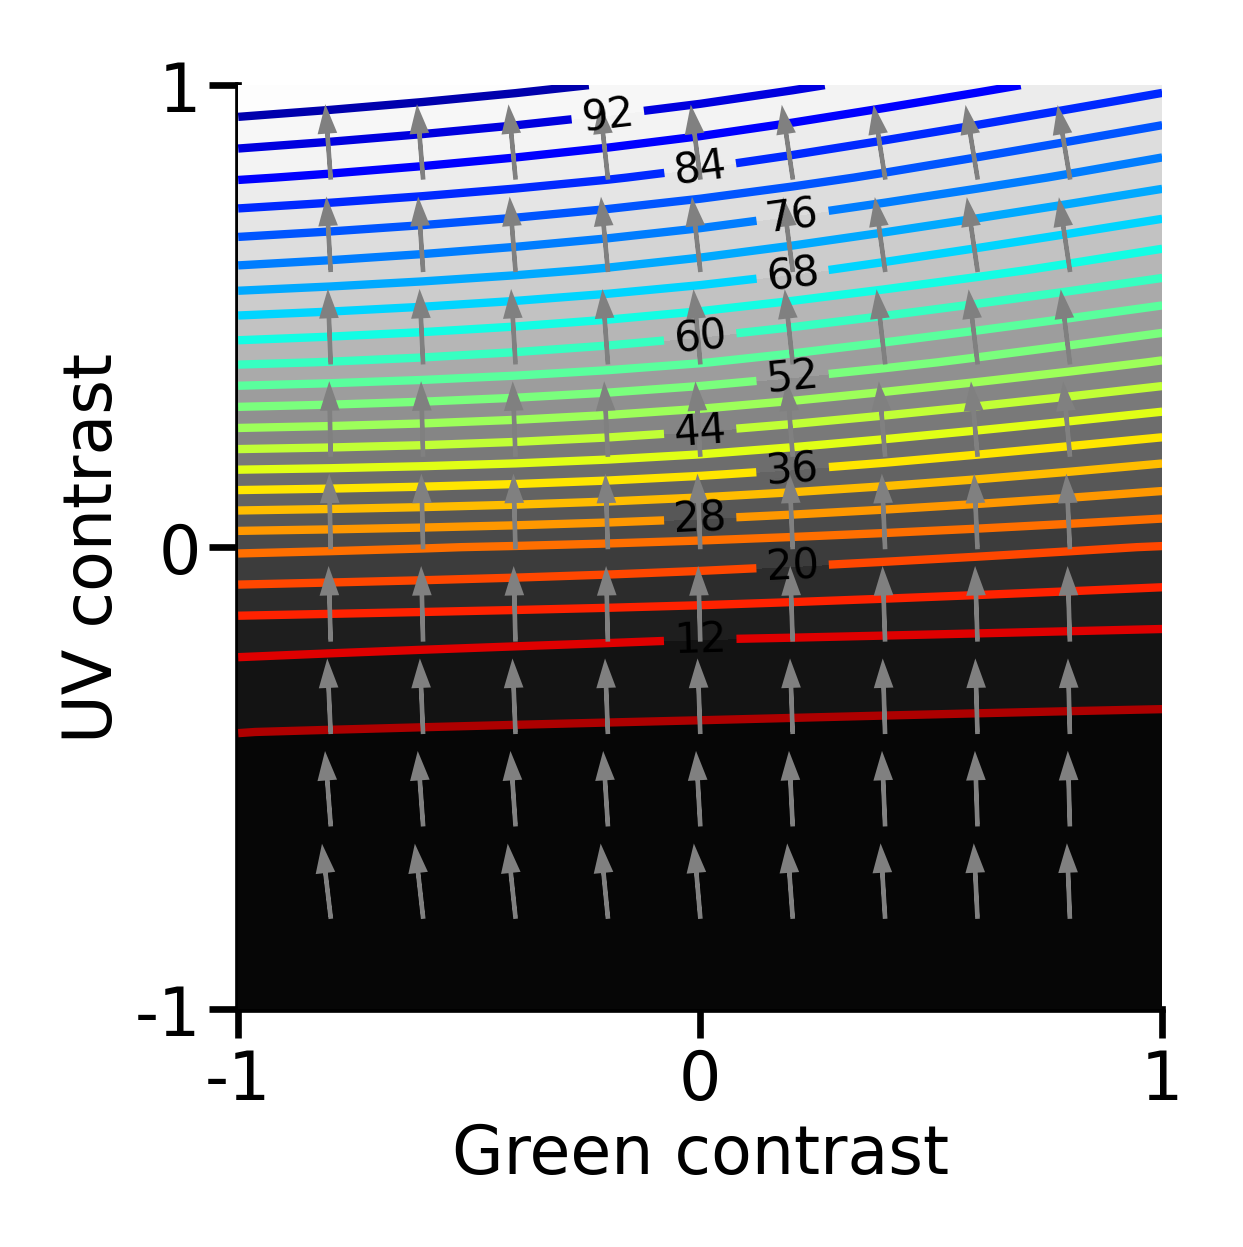

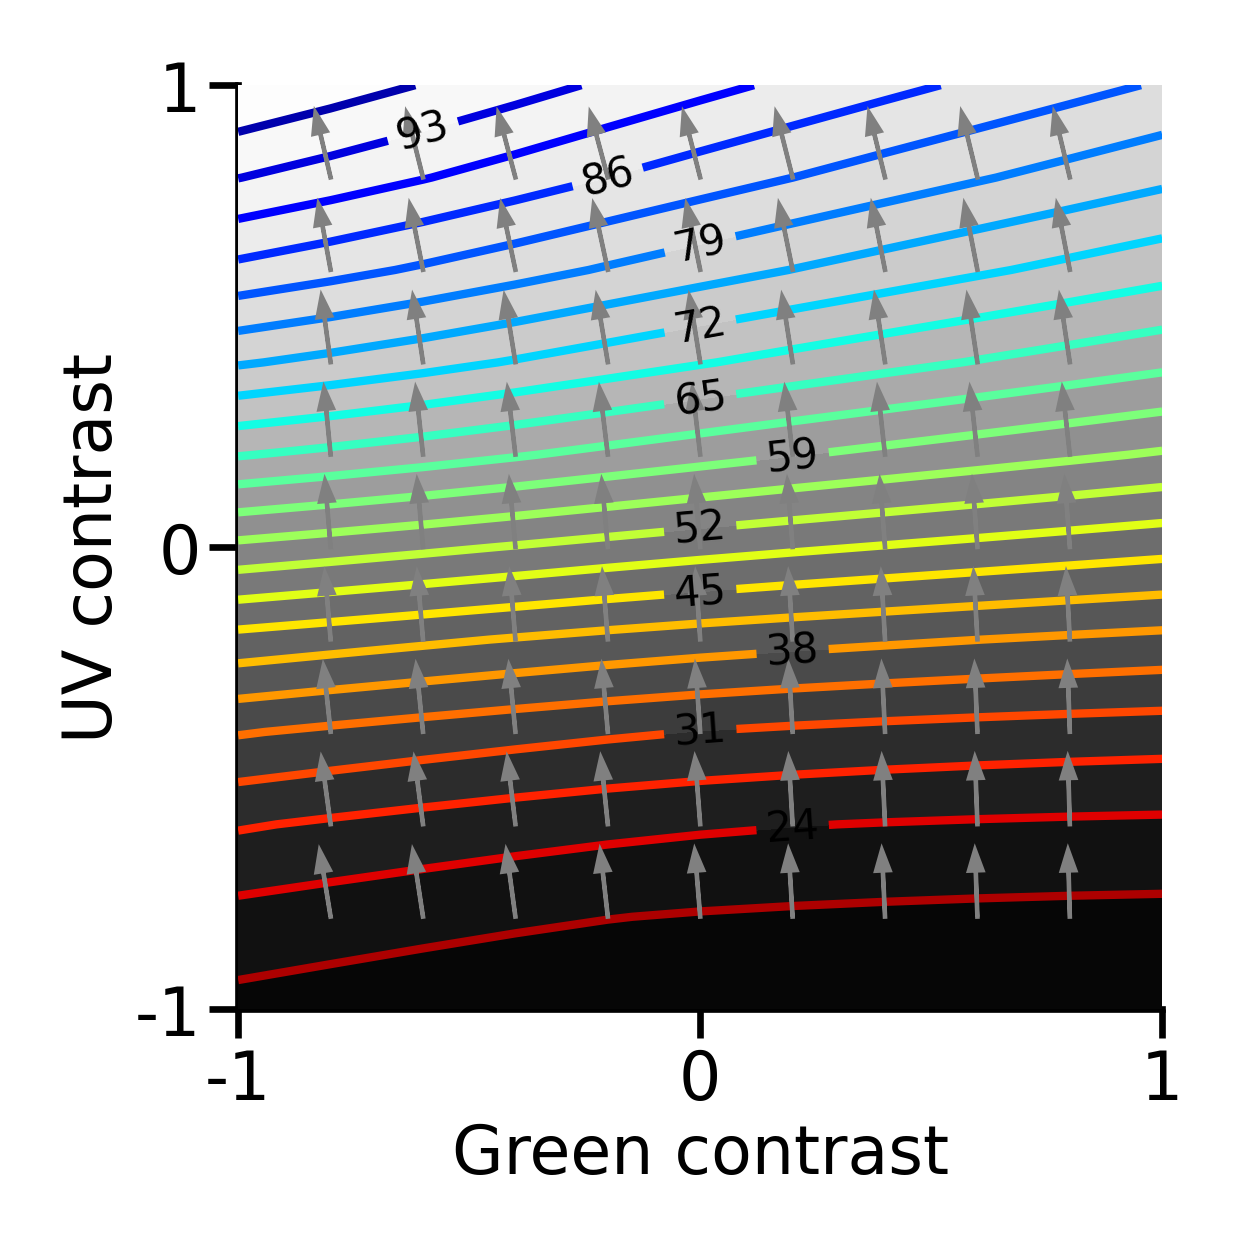

In [34]:
for neuron_id in example_cell_ids:
    x = np.arange(-1, 1.2, .2)
    plot_vector_field_resp_iso(x, x, 
                               norm_grid[model_key][stim_key], 
                               gradient_grid[model_key][stim_key], 
                               resp_grid[model_key][stim_key],
                              neuron_id=neuron_id, normalize_response=True, cmap="Greys_r", rc_dict=rc_dict)
    #save_this(fig_path, '_'.join([neuron_id, 'nonlin']), svg=False)
   #plt.close()

## LN-type model responding to LN-type model generated MEI

In [35]:
model_key = 'LN model'
stim_key = 'LN MEI'

1.1335400000794165
100.0
0.11927068213601108
3.777608119663003
13.26089629382525
100.0
0.3625339739391928
1.3839397021525957


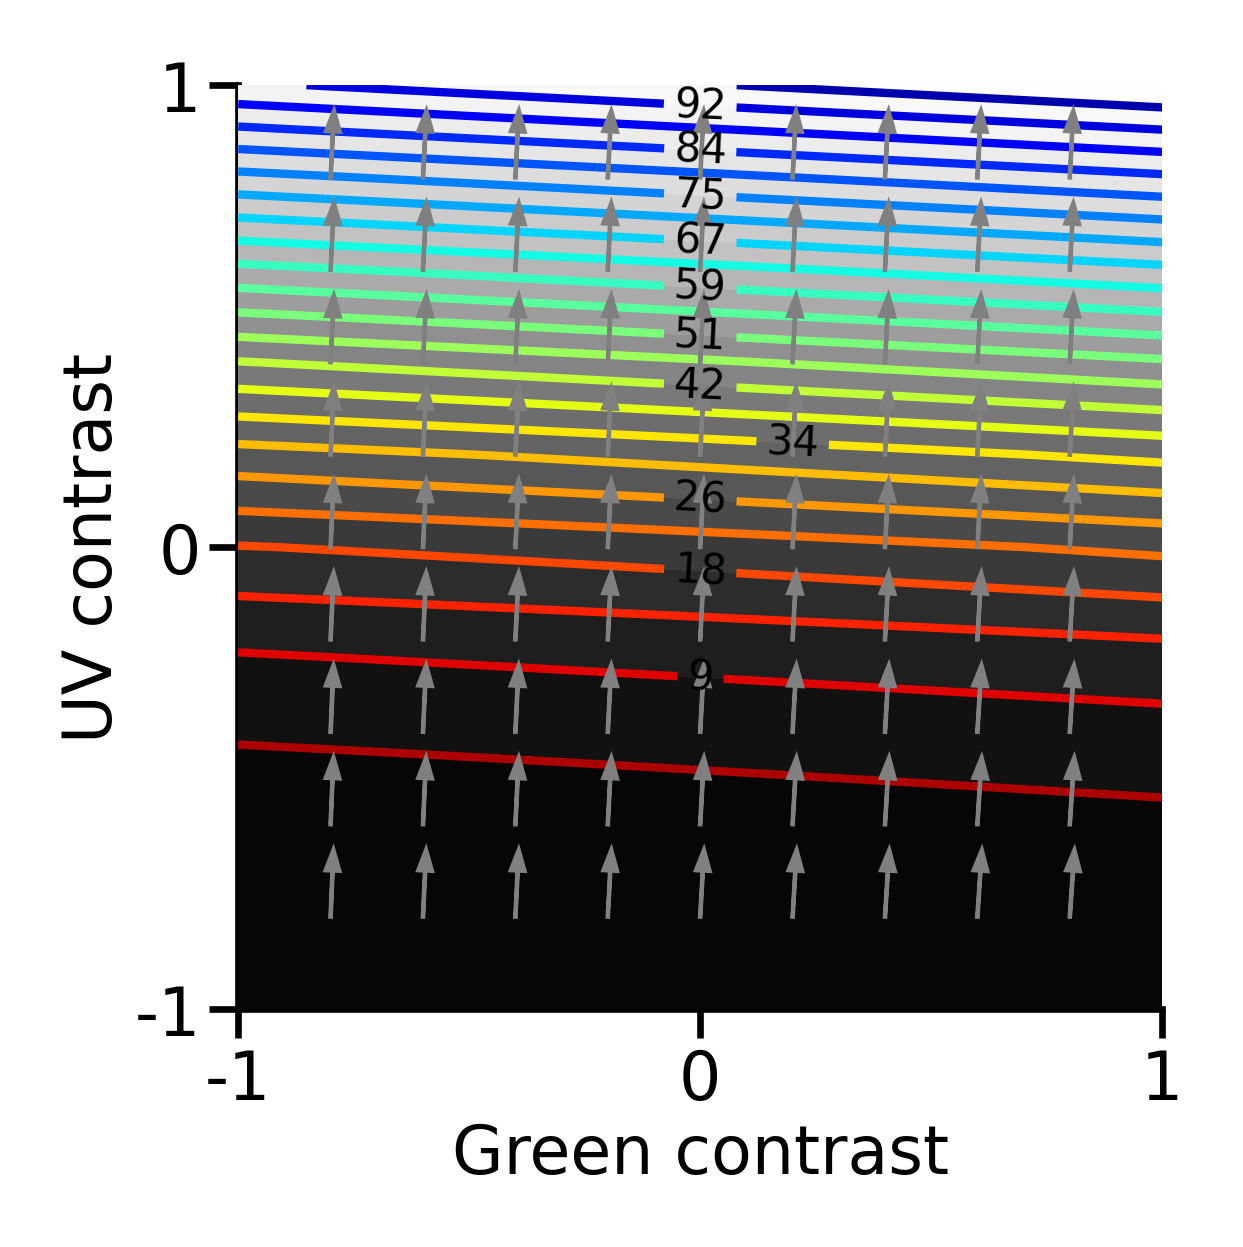

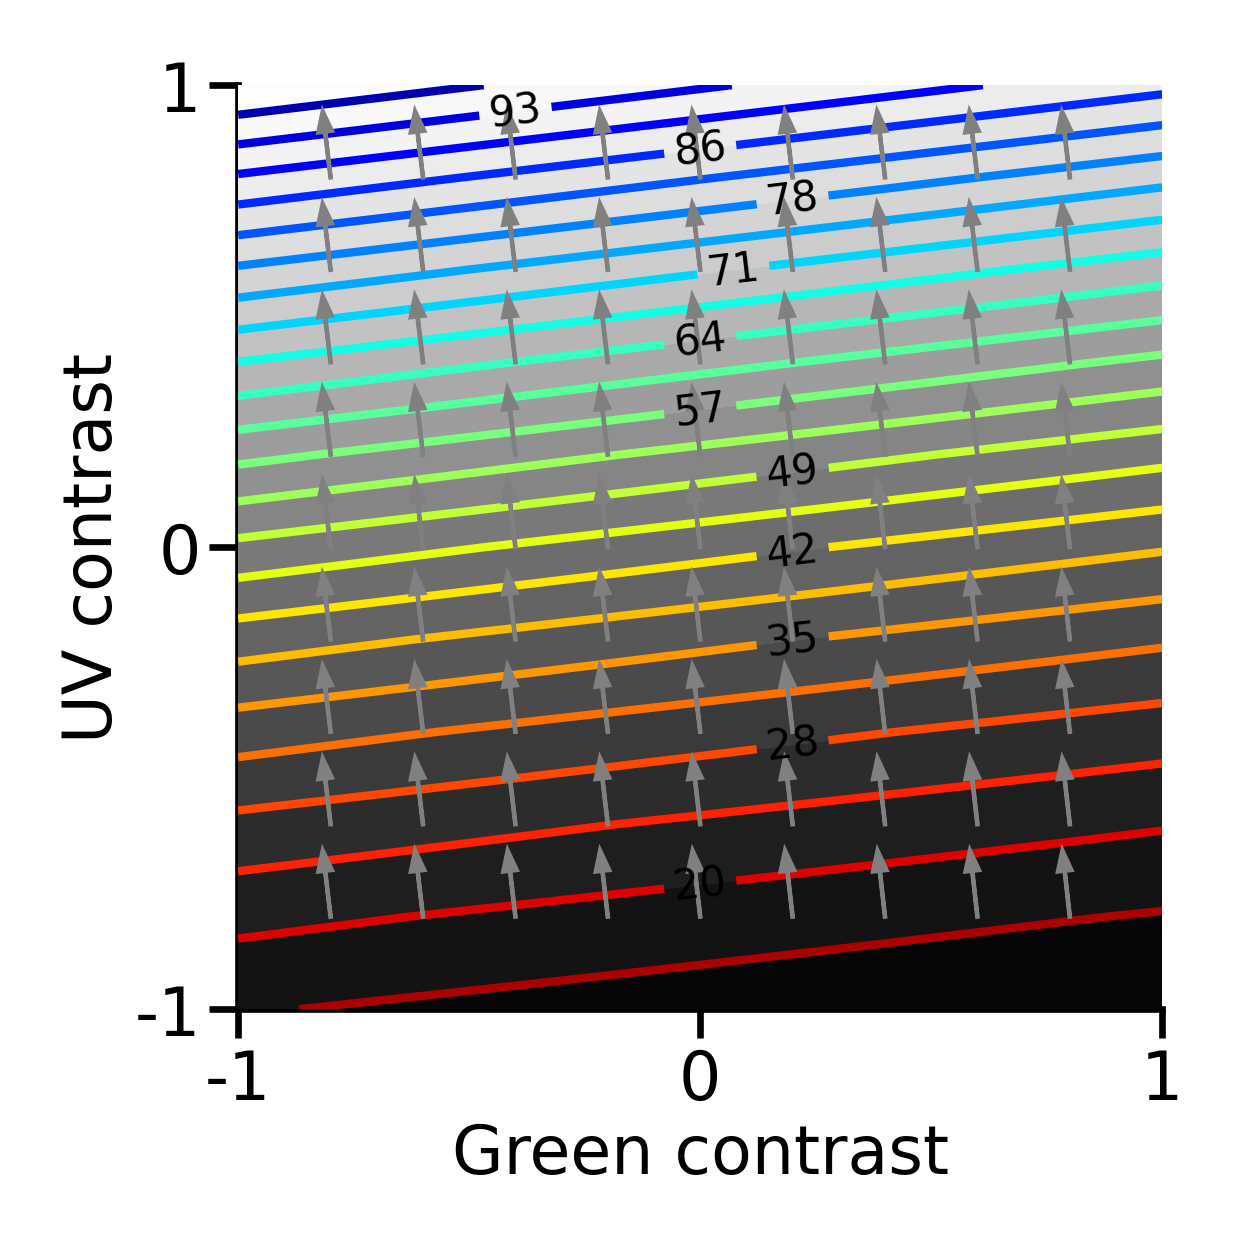

In [36]:
for neuron_id in example_cell_ids:
    x = np.arange(-1, 1.2, .2)
    plot_vector_field_resp_iso(x, x, 
                               norm_grid[model_key][stim_key], 
                               gradient_grid[model_key][stim_key], 
                               resp_grid[model_key][stim_key],
                              neuron_id=neuron_id, normalize_response=True, cmap="Greys_r", rc_dict=rc_dict)
    #save_this(fig_path, '_'.join([neuron_id, 'nonlin']), svg=False)
   #plt.close()

## plot response difference

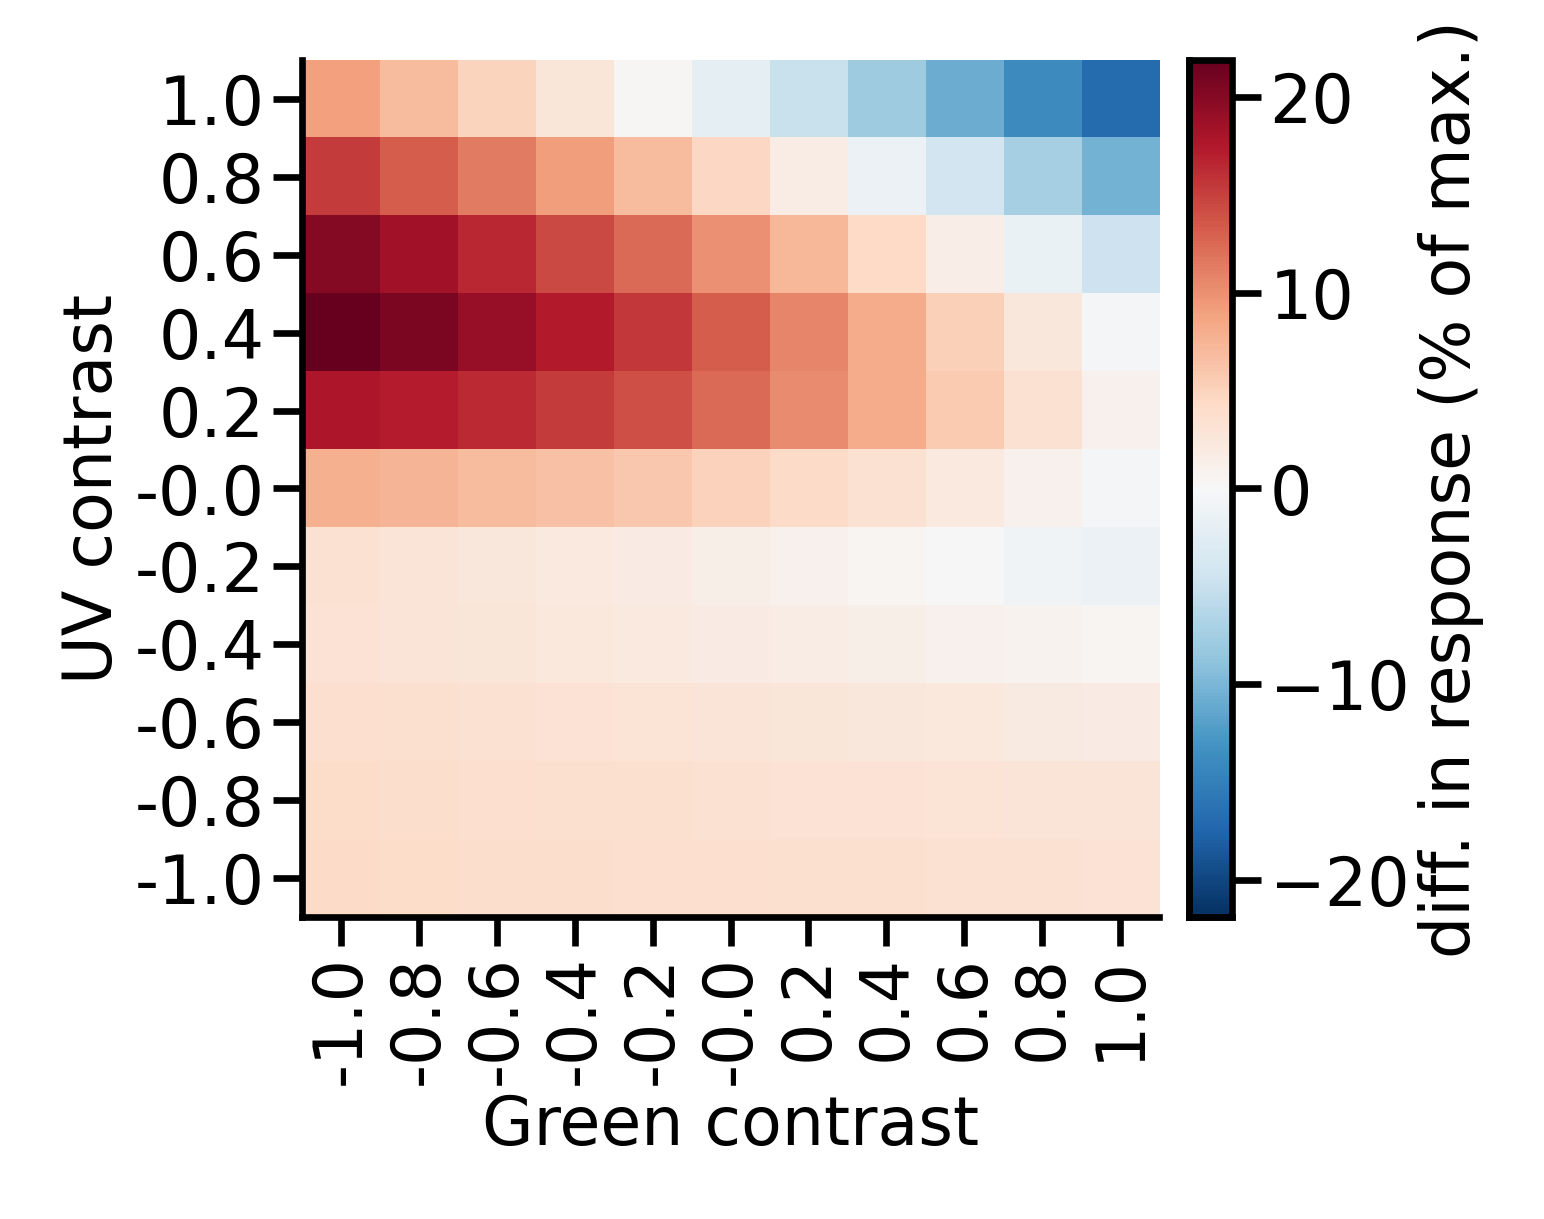

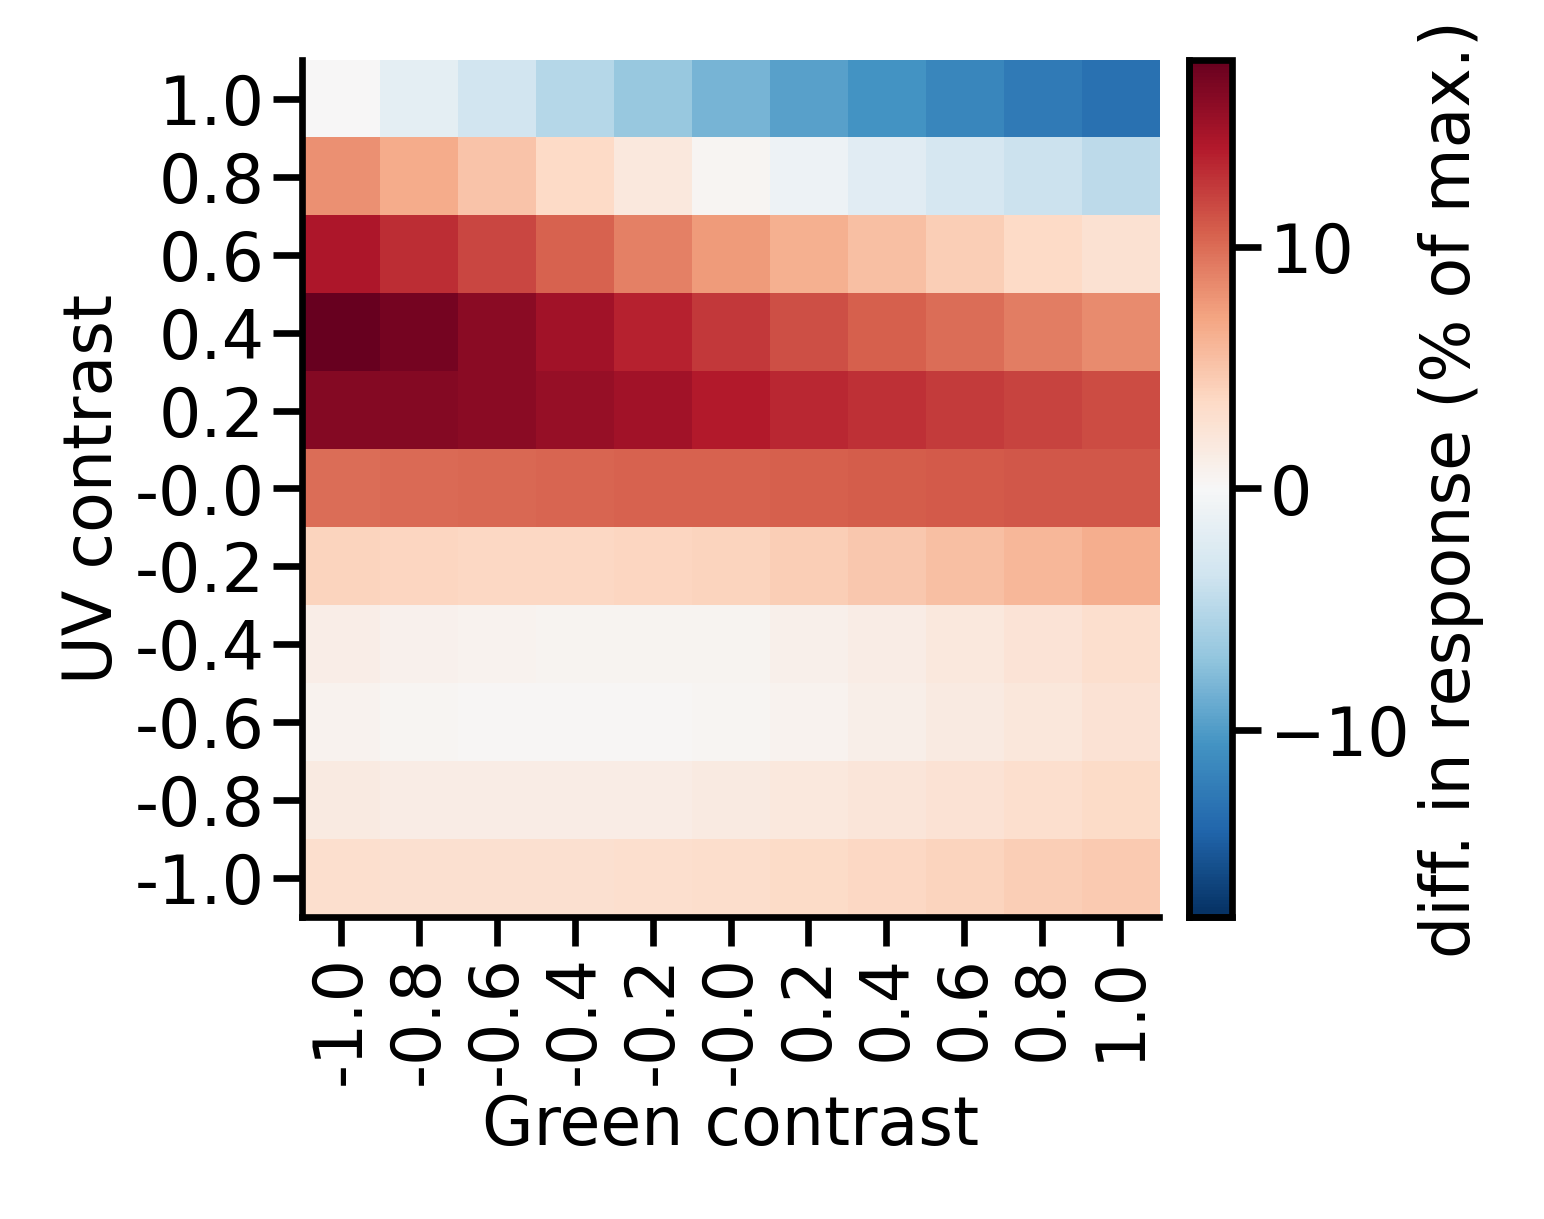

In [39]:
for neuron_id in example_cell_ids:
    plot_resp_diff(resp_grid['CNN model']['LN MEI'],
                   resp_grid['LN model']['LN MEI'],
                   neuron_id, x, 
                  rc_dict=rc_dict);

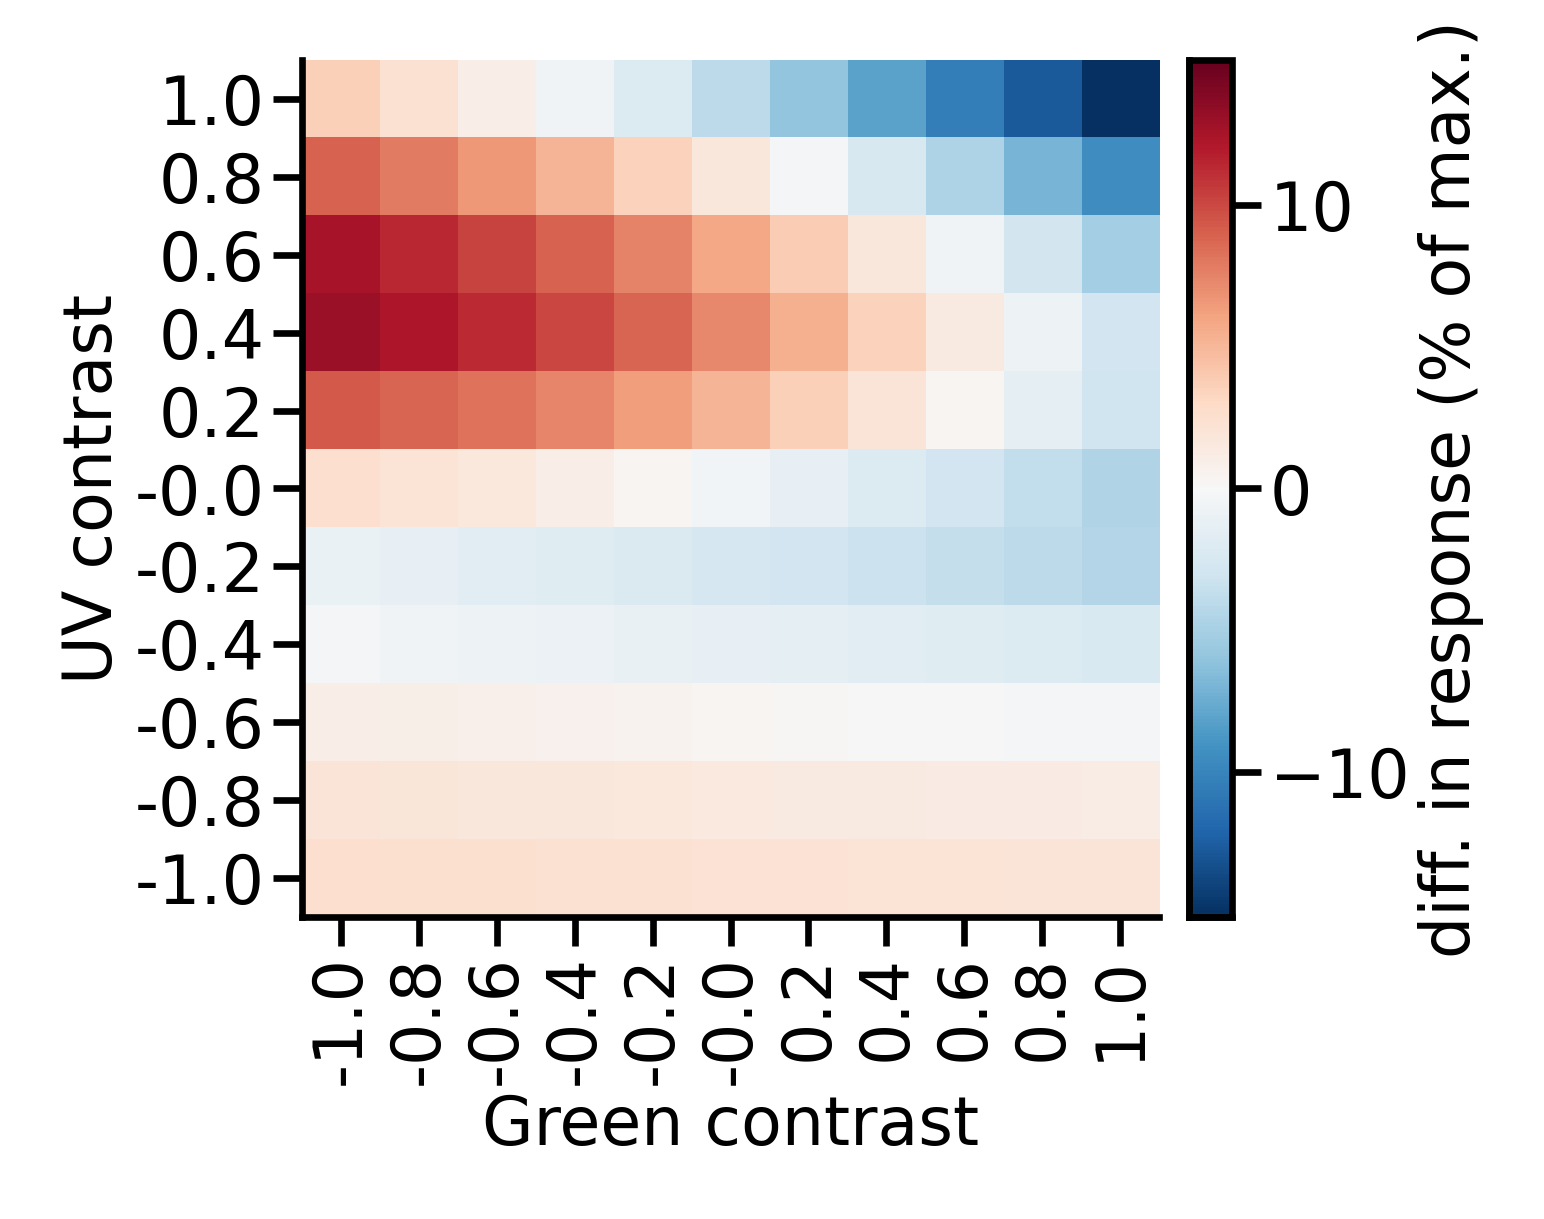

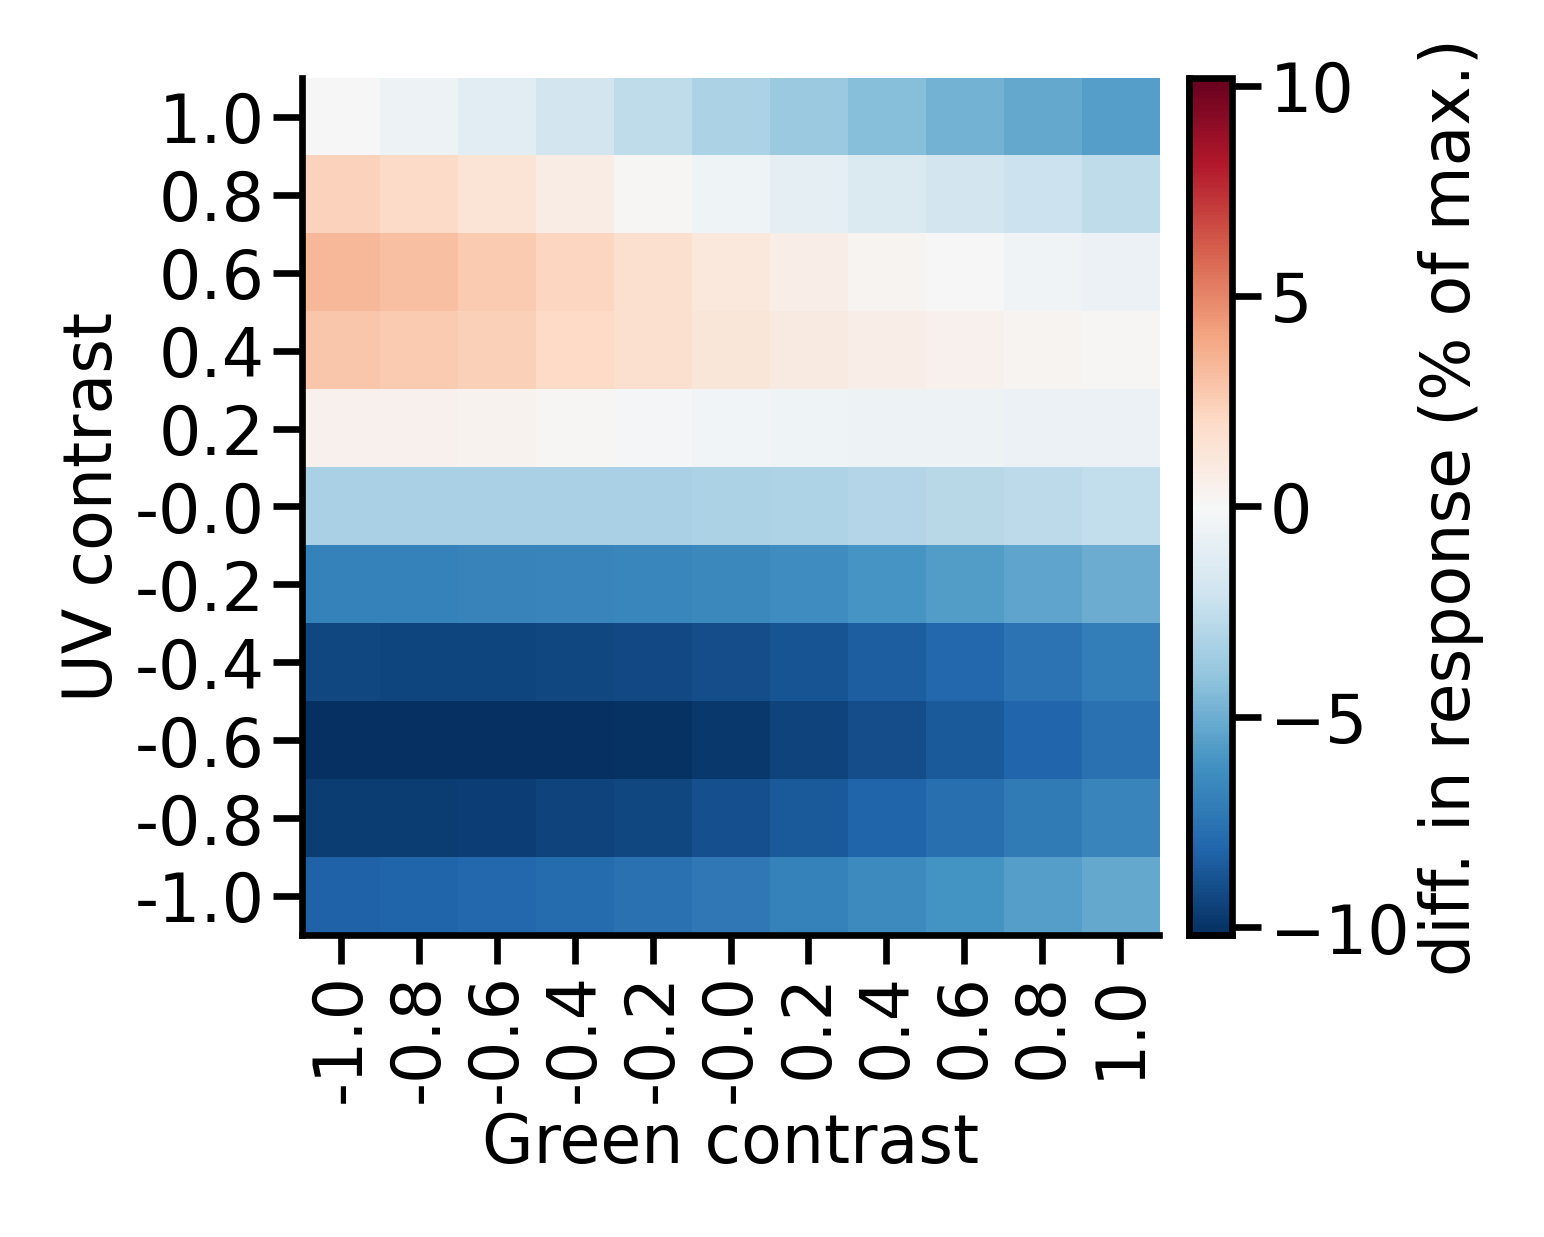

In [38]:
for neuron_id in example_cell_ids:
    plot_resp_diff(resp_grid['CNN model']['CNN MEI'],
                   resp_grid['LN model']['CNN MEI'],
                   neuron_id, x, 
                  rc_dict=rc_dict);